# **Assignment 6**

---



1. Run this [network](https://colab.research.google.com/drive/1qlewMtxcAJT6fIJdmMh8pSf2e-dh51Rw)
2. Fix the network above:
  1. change the code such that it uses GPU and
  2. change the architecture to `C1|C2|C3|C4|O` (_No MaxPooling, but 3 3x3 layers with stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then `200pts extra!`_)
  3. total RF must be more than `44`
  4. one of the layers must use Depthwise Separable Convolution
  5. one of the layers must use Dilated Convolution
  6. use GAP (_compulsory_):- add FC after GAP to target # of classes (_optional_)
  7. use albumentation library and apply:
    - horizontal flip
    - shiftScaleRotate
    - coarseDropout (`max_holes = 1, max_height=16px, min_width=1, min_holes = 1, min_height=16px, max_width=16px, fill_value=(mean of your dataset), mask_fill_value = None`)
  8. achieve `85% accuracy`, as many epochs as you want.
  9. Total Params to be less than `200k`.
3. Upload to Github
4. Attempt S6-Assignment Solution.
5. Questions in the Assignment QnA are:
  1. copy paste your model code from your model.py file (full code) `[125]`
  2. copy paste output of torchsummary `[125]`
  3. copy-paste the code where you implemented albumentation transformation for all three transformations `[125]`
  4. copy paste your training log (you must be running validation/text after each Epoch `[125]`
  5. Share the link for your README.md file. `[200]`


---



# **Clone Repo and install dependencies**

In [13]:
!git clone https://github.com/abhyuditjain/eva-8
!mv eva-8/session6/* ./
!rm -rf eva-8
!pip install -r requirements.txt

Cloning into 'eva-8'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 164 (delta 74), reused 142 (delta 52), pack-reused 0
Receiving objects: 100% (164/164), 2.12 MiB | 7.42 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Print Model**

In [14]:
!cat model.py

import torch.nn.functional as F
import torch.nn as nn

dropout_value = 0.05


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        """
        CONVOLUTION BLOCK 1
        NIn    RFIn   KernelSize  Padding    Stride  JumpIn  JumpOut   RFOut     NOut       Notes
        32      1       5           2           1       1       1        5        32     Normal Conv
        32      5       3           1           1       1       1        7        32     Normal Conv
        32      7       3           1           1       1       1        9        32     Normal Conv
        """
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.B

# **Print Transforms**

In [73]:
!cat transforms.py

from albumentations import (
    Compose,
    Normalize,
    HorizontalFlip,
    CoarseDropout,
    ShiftScaleRotate,
)
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np


class Transforms:
    def __init__(self, means, stds, train=True):
        if train:
            self.transformations = Compose(
                [
                    HorizontalFlip(),
                    ShiftScaleRotate(),
                    CoarseDropout(
                        min_holes=1,
                        max_holes=1,
                        min_height=16,
                        max_height=16,
                        min_width=16,
                        max_width=16,
                        fill_value=[x * 255 for x in means],  # type: ignore
                        mask_fill_value=None,
                    ),
                    Normalize(mean=means, std=stds),
                    ToTensorV2(),
                ]
            )
        else:
            self.transformations = 

# **Model Summary**

In [15]:
import torch
from model import Net
from torchinfo import summary


def print_summary(model):
    batch_size = 20
    summary(
        model,
        input_size=(batch_size, 3, 32, 32),
        verbose=1,
        col_names=[
            "kernel_size",
            "input_size",
            "output_size",
            "num_params",
            "mult_adds",
            "trainable",
        ],
        row_settings=["var_names"],
    )

is_cuda_available = torch.cuda.is_available()
print("Is GPU available?", is_cuda_available)
device = torch.device("cuda" if is_cuda_available else "cpu")
model = Net().to(device=device)

print_summary(model)

Is GPU available? True
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net (Net)                                --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Sequential (conv_block1)               --                        [20, 3, 32, 32]           [20, 32, 32, 32]          --                        --                        True
│    └─Conv2d (0)                        [5, 5]                    [20, 3, 32, 32]           [20, 128, 32, 32]         9,600                     196,608,000               True
│    └─ReLU (1)                          --                        [20, 128, 32, 32]         [20, 128, 32, 32]         --                        --                        --
│    └─BatchNorm2d (2)                   --                        [20, 128, 32, 32]         [

# **Initialize Dataloaders for Training and Testing**

In [16]:
from dataloader import Cifar10DataLoader

cifar10 = Cifar10DataLoader(is_cuda_available=is_cuda_available)
train_loader = cifar10.get_loader(True)
test_loader = cifar10.get_loader(False)

Files already downloaded and verified
Files already downloaded and verified


# **Train the model**

In [17]:
import torch.optim as optim
import torch.nn as nn
from train import Trainer
from test import Tester

trainer = Trainer()
tester = Tester()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.NLLLoss()

EPOCHS = 200

for epoch in range(EPOCHS):
    trainer.train(model, train_loader, optimizer, criterion, device, epoch)
    tester.test(model, test_loader, criterion, device)

EPOCH = 0 | LR = 0.001 | Loss = 1.74 | Batch = 390 | Accuracy = 24.84: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


Test set: Average loss: 0.0135, Accuracy: 3582/10000 (35.82%)



EPOCH = 1 | LR = 0.001 | Loss = 1.64 | Batch = 390 | Accuracy = 36.71: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]


Test set: Average loss: 0.0118, Accuracy: 4431/10000 (44.31%)



EPOCH = 2 | LR = 0.001 | Loss = 1.41 | Batch = 390 | Accuracy = 40.85: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s]


Test set: Average loss: 0.0111, Accuracy: 4721/10000 (47.21%)



EPOCH = 3 | LR = 0.001 | Loss = 1.41 | Batch = 390 | Accuracy = 44.04: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]


Test set: Average loss: 0.0105, Accuracy: 5070/10000 (50.70%)



EPOCH = 4 | LR = 0.001 | Loss = 1.45 | Batch = 390 | Accuracy = 46.93: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Test set: Average loss: 0.0100, Accuracy: 5366/10000 (53.66%)



EPOCH = 5 | LR = 0.001 | Loss = 1.45 | Batch = 390 | Accuracy = 49.10: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0093, Accuracy: 5690/10000 (56.90%)



EPOCH = 6 | LR = 0.001 | Loss = 1.54 | Batch = 390 | Accuracy = 50.79: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0092, Accuracy: 5818/10000 (58.18%)



EPOCH = 7 | LR = 0.001 | Loss = 1.17 | Batch = 390 | Accuracy = 52.65: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0087, Accuracy: 6008/10000 (60.08%)



EPOCH = 8 | LR = 0.001 | Loss = 1.26 | Batch = 390 | Accuracy = 53.81: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0088, Accuracy: 6035/10000 (60.35%)



EPOCH = 9 | LR = 0.001 | Loss = 1.33 | Batch = 390 | Accuracy = 55.13: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0084, Accuracy: 6188/10000 (61.88%)



EPOCH = 10 | LR = 0.001 | Loss = 1.28 | Batch = 390 | Accuracy = 56.14: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0079, Accuracy: 6416/10000 (64.16%)



EPOCH = 11 | LR = 0.001 | Loss = 1.25 | Batch = 390 | Accuracy = 57.03: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0076, Accuracy: 6525/10000 (65.25%)



EPOCH = 12 | LR = 0.001 | Loss = 1.25 | Batch = 390 | Accuracy = 57.85: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0078, Accuracy: 6511/10000 (65.11%)



EPOCH = 13 | LR = 0.001 | Loss = 1.22 | Batch = 390 | Accuracy = 58.44: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0075, Accuracy: 6616/10000 (66.16%)



EPOCH = 14 | LR = 0.001 | Loss = 1.02 | Batch = 390 | Accuracy = 59.11: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Test set: Average loss: 0.0074, Accuracy: 6683/10000 (66.83%)



EPOCH = 15 | LR = 0.001 | Loss = 1.01 | Batch = 390 | Accuracy = 59.94: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0073, Accuracy: 6734/10000 (67.34%)



EPOCH = 16 | LR = 0.001 | Loss = 1.07 | Batch = 390 | Accuracy = 60.71: 100%|██████████| 391/391 [00:23<00:00, 16.60it/s]


Test set: Average loss: 0.0070, Accuracy: 6846/10000 (68.46%)



EPOCH = 17 | LR = 0.001 | Loss = 1.12 | Batch = 390 | Accuracy = 61.33: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0067, Accuracy: 6961/10000 (69.61%)



EPOCH = 18 | LR = 0.001 | Loss = 1.34 | Batch = 390 | Accuracy = 61.84: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0067, Accuracy: 6980/10000 (69.80%)



EPOCH = 19 | LR = 0.001 | Loss = 1.23 | Batch = 390 | Accuracy = 62.22: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]


Test set: Average loss: 0.0065, Accuracy: 7074/10000 (70.74%)



EPOCH = 20 | LR = 0.001 | Loss = 1.23 | Batch = 390 | Accuracy = 62.69: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]


Test set: Average loss: 0.0066, Accuracy: 7059/10000 (70.59%)



EPOCH = 21 | LR = 0.001 | Loss = 1.03 | Batch = 390 | Accuracy = 63.38: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


Test set: Average loss: 0.0066, Accuracy: 7043/10000 (70.43%)



EPOCH = 22 | LR = 0.001 | Loss = 1.00 | Batch = 390 | Accuracy = 63.83: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0062, Accuracy: 7242/10000 (72.42%)



EPOCH = 23 | LR = 0.001 | Loss = 0.87 | Batch = 390 | Accuracy = 64.27: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Test set: Average loss: 0.0062, Accuracy: 7277/10000 (72.77%)



EPOCH = 24 | LR = 0.001 | Loss = 1.08 | Batch = 390 | Accuracy = 64.63: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]


Test set: Average loss: 0.0062, Accuracy: 7245/10000 (72.45%)



EPOCH = 25 | LR = 0.001 | Loss = 1.09 | Batch = 390 | Accuracy = 65.11: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0061, Accuracy: 7275/10000 (72.75%)



EPOCH = 26 | LR = 0.001 | Loss = 1.01 | Batch = 390 | Accuracy = 65.24: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0060, Accuracy: 7420/10000 (74.20%)



EPOCH = 27 | LR = 0.001 | Loss = 0.95 | Batch = 390 | Accuracy = 65.64: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0058, Accuracy: 7378/10000 (73.78%)



EPOCH = 28 | LR = 0.001 | Loss = 1.10 | Batch = 390 | Accuracy = 66.02: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0057, Accuracy: 7529/10000 (75.29%)



EPOCH = 29 | LR = 0.001 | Loss = 1.13 | Batch = 390 | Accuracy = 66.28: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0057, Accuracy: 7505/10000 (75.05%)



EPOCH = 30 | LR = 0.001 | Loss = 1.08 | Batch = 390 | Accuracy = 66.36: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0059, Accuracy: 7444/10000 (74.44%)



EPOCH = 31 | LR = 0.001 | Loss = 0.87 | Batch = 390 | Accuracy = 66.63: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0055, Accuracy: 7585/10000 (75.85%)



EPOCH = 32 | LR = 0.001 | Loss = 1.12 | Batch = 390 | Accuracy = 66.74: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0055, Accuracy: 7561/10000 (75.61%)



EPOCH = 33 | LR = 0.001 | Loss = 1.03 | Batch = 390 | Accuracy = 67.23: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0054, Accuracy: 7597/10000 (75.97%)



EPOCH = 34 | LR = 0.001 | Loss = 0.94 | Batch = 390 | Accuracy = 67.63: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0054, Accuracy: 7588/10000 (75.88%)



EPOCH = 35 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 67.51: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0055, Accuracy: 7584/10000 (75.84%)



EPOCH = 36 | LR = 0.001 | Loss = 1.20 | Batch = 390 | Accuracy = 68.03: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0054, Accuracy: 7681/10000 (76.81%)



EPOCH = 37 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 68.22: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0052, Accuracy: 7728/10000 (77.28%)



EPOCH = 38 | LR = 0.001 | Loss = 0.93 | Batch = 390 | Accuracy = 68.44: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]


Test set: Average loss: 0.0053, Accuracy: 7665/10000 (76.65%)



EPOCH = 39 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 68.77: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0052, Accuracy: 7685/10000 (76.85%)



EPOCH = 40 | LR = 0.001 | Loss = 1.02 | Batch = 390 | Accuracy = 68.80: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s]


Test set: Average loss: 0.0051, Accuracy: 7811/10000 (78.11%)



EPOCH = 41 | LR = 0.001 | Loss = 1.12 | Batch = 390 | Accuracy = 69.07: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]


Test set: Average loss: 0.0053, Accuracy: 7680/10000 (76.80%)



EPOCH = 42 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 69.13: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0051, Accuracy: 7751/10000 (77.51%)



EPOCH = 43 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 69.51: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]


Test set: Average loss: 0.0050, Accuracy: 7863/10000 (78.63%)



EPOCH = 44 | LR = 0.001 | Loss = 0.99 | Batch = 390 | Accuracy = 69.58: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0052, Accuracy: 7747/10000 (77.47%)



EPOCH = 45 | LR = 0.001 | Loss = 0.87 | Batch = 390 | Accuracy = 69.68: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0049, Accuracy: 7834/10000 (78.34%)



EPOCH = 46 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 69.89: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0049, Accuracy: 7868/10000 (78.68%)



EPOCH = 47 | LR = 0.001 | Loss = 1.04 | Batch = 390 | Accuracy = 69.90: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0050, Accuracy: 7802/10000 (78.02%)



EPOCH = 48 | LR = 0.001 | Loss = 1.19 | Batch = 390 | Accuracy = 70.18: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0049, Accuracy: 7872/10000 (78.72%)



EPOCH = 49 | LR = 0.001 | Loss = 0.90 | Batch = 390 | Accuracy = 70.41: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0048, Accuracy: 7883/10000 (78.83%)



EPOCH = 50 | LR = 0.001 | Loss = 0.91 | Batch = 390 | Accuracy = 70.43: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0048, Accuracy: 7891/10000 (78.91%)



EPOCH = 51 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 70.63: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0047, Accuracy: 7971/10000 (79.71%)



EPOCH = 52 | LR = 0.001 | Loss = 0.85 | Batch = 390 | Accuracy = 70.73: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0049, Accuracy: 7900/10000 (79.00%)



EPOCH = 53 | LR = 0.001 | Loss = 0.82 | Batch = 390 | Accuracy = 70.80: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]


Test set: Average loss: 0.0046, Accuracy: 8008/10000 (80.08%)



EPOCH = 54 | LR = 0.001 | Loss = 0.82 | Batch = 390 | Accuracy = 71.01: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0047, Accuracy: 7943/10000 (79.43%)



EPOCH = 55 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 71.18: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0046, Accuracy: 7994/10000 (79.94%)



EPOCH = 56 | LR = 0.001 | Loss = 0.92 | Batch = 390 | Accuracy = 71.32: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0046, Accuracy: 8007/10000 (80.07%)



EPOCH = 57 | LR = 0.001 | Loss = 0.84 | Batch = 390 | Accuracy = 71.70: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0047, Accuracy: 7982/10000 (79.82%)



EPOCH = 58 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 71.74: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0047, Accuracy: 7925/10000 (79.25%)



EPOCH = 59 | LR = 0.001 | Loss = 0.87 | Batch = 390 | Accuracy = 71.79: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0045, Accuracy: 8048/10000 (80.48%)



EPOCH = 60 | LR = 0.001 | Loss = 1.02 | Batch = 390 | Accuracy = 71.50: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0045, Accuracy: 8064/10000 (80.64%)



EPOCH = 61 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 71.87: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0045, Accuracy: 8052/10000 (80.52%)



EPOCH = 62 | LR = 0.001 | Loss = 0.93 | Batch = 390 | Accuracy = 72.12: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0045, Accuracy: 8083/10000 (80.83%)



EPOCH = 63 | LR = 0.001 | Loss = 0.95 | Batch = 390 | Accuracy = 72.31: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0045, Accuracy: 8084/10000 (80.84%)



EPOCH = 64 | LR = 0.001 | Loss = 0.91 | Batch = 390 | Accuracy = 72.28: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]


Test set: Average loss: 0.0046, Accuracy: 7990/10000 (79.90%)



EPOCH = 65 | LR = 0.001 | Loss = 1.12 | Batch = 390 | Accuracy = 72.34: 100%|██████████| 391/391 [00:22<00:00, 17.03it/s]


Test set: Average loss: 0.0043, Accuracy: 8094/10000 (80.94%)



EPOCH = 66 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 72.27: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0044, Accuracy: 8055/10000 (80.55%)



EPOCH = 67 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 72.57: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]


Test set: Average loss: 0.0044, Accuracy: 8089/10000 (80.89%)



EPOCH = 68 | LR = 0.001 | Loss = 0.85 | Batch = 390 | Accuracy = 72.39: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0043, Accuracy: 8102/10000 (81.02%)



EPOCH = 69 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 72.88: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Test set: Average loss: 0.0044, Accuracy: 8126/10000 (81.26%)



EPOCH = 70 | LR = 0.001 | Loss = 0.72 | Batch = 390 | Accuracy = 72.90: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0044, Accuracy: 8126/10000 (81.26%)



EPOCH = 71 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 72.74: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0044, Accuracy: 8126/10000 (81.26%)



EPOCH = 72 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 73.34: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0042, Accuracy: 8179/10000 (81.79%)



EPOCH = 73 | LR = 0.001 | Loss = 0.74 | Batch = 390 | Accuracy = 73.32: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0042, Accuracy: 8185/10000 (81.85%)



EPOCH = 74 | LR = 0.001 | Loss = 0.77 | Batch = 390 | Accuracy = 73.20: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0042, Accuracy: 8147/10000 (81.47%)



EPOCH = 75 | LR = 0.001 | Loss = 0.99 | Batch = 390 | Accuracy = 73.39: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0043, Accuracy: 8140/10000 (81.40%)



EPOCH = 76 | LR = 0.001 | Loss = 0.56 | Batch = 390 | Accuracy = 73.20: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0041, Accuracy: 8234/10000 (82.34%)



EPOCH = 77 | LR = 0.001 | Loss = 0.91 | Batch = 390 | Accuracy = 73.41: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0041, Accuracy: 8254/10000 (82.54%)



EPOCH = 78 | LR = 0.001 | Loss = 0.76 | Batch = 390 | Accuracy = 73.76: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Test set: Average loss: 0.0041, Accuracy: 8211/10000 (82.11%)



EPOCH = 79 | LR = 0.001 | Loss = 0.90 | Batch = 390 | Accuracy = 73.57: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Test set: Average loss: 0.0042, Accuracy: 8191/10000 (81.91%)



EPOCH = 80 | LR = 0.001 | Loss = 0.59 | Batch = 390 | Accuracy = 73.40: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0041, Accuracy: 8240/10000 (82.40%)



EPOCH = 81 | LR = 0.001 | Loss = 1.00 | Batch = 390 | Accuracy = 73.79: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0042, Accuracy: 8235/10000 (82.35%)



EPOCH = 82 | LR = 0.001 | Loss = 0.82 | Batch = 390 | Accuracy = 73.69: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0041, Accuracy: 8218/10000 (82.18%)



EPOCH = 83 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 74.10: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0040, Accuracy: 8253/10000 (82.53%)



EPOCH = 84 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 74.12: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Test set: Average loss: 0.0041, Accuracy: 8290/10000 (82.90%)



EPOCH = 85 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 73.74: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0040, Accuracy: 8265/10000 (82.65%)



EPOCH = 86 | LR = 0.001 | Loss = 0.59 | Batch = 390 | Accuracy = 74.22: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0041, Accuracy: 8241/10000 (82.41%)



EPOCH = 87 | LR = 0.001 | Loss = 0.87 | Batch = 390 | Accuracy = 74.02: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s]


Test set: Average loss: 0.0041, Accuracy: 8271/10000 (82.71%)



EPOCH = 88 | LR = 0.001 | Loss = 0.55 | Batch = 390 | Accuracy = 74.19: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0041, Accuracy: 8224/10000 (82.24%)



EPOCH = 89 | LR = 0.001 | Loss = 0.96 | Batch = 390 | Accuracy = 74.21: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0040, Accuracy: 8259/10000 (82.59%)



EPOCH = 90 | LR = 0.001 | Loss = 0.93 | Batch = 390 | Accuracy = 74.32: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s]


Test set: Average loss: 0.0040, Accuracy: 8326/10000 (83.26%)



EPOCH = 91 | LR = 0.001 | Loss = 0.68 | Batch = 390 | Accuracy = 74.48: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0041, Accuracy: 8251/10000 (82.51%)



EPOCH = 92 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 74.67: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0039, Accuracy: 8333/10000 (83.33%)



EPOCH = 93 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 75.02: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0041, Accuracy: 8236/10000 (82.36%)



EPOCH = 94 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 74.89: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0039, Accuracy: 8309/10000 (83.09%)



EPOCH = 95 | LR = 0.001 | Loss = 0.69 | Batch = 390 | Accuracy = 74.88: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]


Test set: Average loss: 0.0040, Accuracy: 8314/10000 (83.14%)



EPOCH = 96 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 74.84: 100%|██████████| 391/391 [00:23<00:00, 16.89it/s]


Test set: Average loss: 0.0039, Accuracy: 8331/10000 (83.31%)



EPOCH = 97 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 75.16: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s]


Test set: Average loss: 0.0039, Accuracy: 8341/10000 (83.41%)



EPOCH = 98 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 75.12: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0038, Accuracy: 8333/10000 (83.33%)



EPOCH = 99 | LR = 0.001 | Loss = 0.68 | Batch = 390 | Accuracy = 74.80: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0039, Accuracy: 8340/10000 (83.40%)



EPOCH = 100 | LR = 0.001 | Loss = 0.77 | Batch = 390 | Accuracy = 75.18: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0039, Accuracy: 8330/10000 (83.30%)



EPOCH = 101 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 75.15: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0038, Accuracy: 8374/10000 (83.74%)



EPOCH = 102 | LR = 0.001 | Loss = 0.84 | Batch = 390 | Accuracy = 75.15: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0039, Accuracy: 8335/10000 (83.35%)



EPOCH = 103 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 75.07: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0038, Accuracy: 8380/10000 (83.80%)



EPOCH = 104 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 75.42: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0038, Accuracy: 8372/10000 (83.72%)



EPOCH = 105 | LR = 0.001 | Loss = 0.79 | Batch = 390 | Accuracy = 75.23: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0039, Accuracy: 8338/10000 (83.38%)



EPOCH = 106 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 75.13: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0040, Accuracy: 8303/10000 (83.03%)



EPOCH = 107 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 75.54: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0038, Accuracy: 8335/10000 (83.35%)



EPOCH = 108 | LR = 0.001 | Loss = 0.79 | Batch = 390 | Accuracy = 75.48: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0038, Accuracy: 8371/10000 (83.71%)



EPOCH = 109 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 75.57: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0039, Accuracy: 8363/10000 (83.63%)



EPOCH = 110 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 75.60: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0039, Accuracy: 8346/10000 (83.46%)



EPOCH = 111 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 75.70: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0038, Accuracy: 8378/10000 (83.78%)



EPOCH = 112 | LR = 0.001 | Loss = 0.59 | Batch = 390 | Accuracy = 75.79: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0038, Accuracy: 8373/10000 (83.73%)



EPOCH = 113 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 75.78: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0038, Accuracy: 8371/10000 (83.71%)



EPOCH = 114 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 75.73: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0037, Accuracy: 8402/10000 (84.02%)



EPOCH = 115 | LR = 0.001 | Loss = 0.76 | Batch = 390 | Accuracy = 75.92: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]


Test set: Average loss: 0.0038, Accuracy: 8373/10000 (83.73%)



EPOCH = 116 | LR = 0.001 | Loss = 0.92 | Batch = 390 | Accuracy = 76.16: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0037, Accuracy: 8435/10000 (84.35%)



EPOCH = 117 | LR = 0.001 | Loss = 0.55 | Batch = 390 | Accuracy = 75.95: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0037, Accuracy: 8413/10000 (84.13%)



EPOCH = 118 | LR = 0.001 | Loss = 0.47 | Batch = 390 | Accuracy = 75.81: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0037, Accuracy: 8390/10000 (83.90%)



EPOCH = 119 | LR = 0.001 | Loss = 0.69 | Batch = 390 | Accuracy = 75.79: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0038, Accuracy: 8405/10000 (84.05%)



EPOCH = 120 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 76.10: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0037, Accuracy: 8427/10000 (84.27%)



EPOCH = 121 | LR = 0.001 | Loss = 0.49 | Batch = 390 | Accuracy = 76.04: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0036, Accuracy: 8413/10000 (84.13%)



EPOCH = 122 | LR = 0.001 | Loss = 0.72 | Batch = 390 | Accuracy = 76.29: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0036, Accuracy: 8447/10000 (84.47%)



EPOCH = 123 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 76.33: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0038, Accuracy: 8354/10000 (83.54%)



EPOCH = 124 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 76.38: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0037, Accuracy: 8426/10000 (84.26%)



EPOCH = 125 | LR = 0.001 | Loss = 0.68 | Batch = 390 | Accuracy = 76.38: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0036, Accuracy: 8443/10000 (84.43%)



EPOCH = 126 | LR = 0.001 | Loss = 0.80 | Batch = 390 | Accuracy = 76.58: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0037, Accuracy: 8409/10000 (84.09%)



EPOCH = 127 | LR = 0.001 | Loss = 0.70 | Batch = 390 | Accuracy = 76.43: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0037, Accuracy: 8399/10000 (83.99%)



EPOCH = 128 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 76.57: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0036, Accuracy: 8427/10000 (84.27%)



EPOCH = 129 | LR = 0.001 | Loss = 0.82 | Batch = 390 | Accuracy = 76.38: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0037, Accuracy: 8458/10000 (84.58%)



EPOCH = 130 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 76.55: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0037, Accuracy: 8457/10000 (84.57%)



EPOCH = 131 | LR = 0.001 | Loss = 0.96 | Batch = 390 | Accuracy = 76.37: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0037, Accuracy: 8439/10000 (84.39%)



EPOCH = 132 | LR = 0.001 | Loss = 0.80 | Batch = 390 | Accuracy = 76.72: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0036, Accuracy: 8450/10000 (84.50%)



EPOCH = 133 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 76.54: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0037, Accuracy: 8448/10000 (84.48%)



EPOCH = 134 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 76.53: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0036, Accuracy: 8470/10000 (84.70%)



EPOCH = 135 | LR = 0.001 | Loss = 0.74 | Batch = 390 | Accuracy = 76.91: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0036, Accuracy: 8451/10000 (84.51%)



EPOCH = 136 | LR = 0.001 | Loss = 0.85 | Batch = 390 | Accuracy = 76.78: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0036, Accuracy: 8481/10000 (84.81%)



EPOCH = 137 | LR = 0.001 | Loss = 0.53 | Batch = 390 | Accuracy = 77.12: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0036, Accuracy: 8468/10000 (84.68%)



EPOCH = 138 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 76.86: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]


Test set: Average loss: 0.0036, Accuracy: 8467/10000 (84.67%)



EPOCH = 139 | LR = 0.001 | Loss = 0.55 | Batch = 390 | Accuracy = 76.93: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0035, Accuracy: 8463/10000 (84.63%)



EPOCH = 140 | LR = 0.001 | Loss = 0.55 | Batch = 390 | Accuracy = 76.95: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0036, Accuracy: 8504/10000 (85.04%)



EPOCH = 141 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 76.83: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0036, Accuracy: 8455/10000 (84.55%)



EPOCH = 142 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 77.16: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0036, Accuracy: 8483/10000 (84.83%)



EPOCH = 143 | LR = 0.001 | Loss = 0.70 | Batch = 390 | Accuracy = 77.00: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0036, Accuracy: 8470/10000 (84.70%)



EPOCH = 144 | LR = 0.001 | Loss = 0.51 | Batch = 390 | Accuracy = 77.15: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0036, Accuracy: 8460/10000 (84.60%)



EPOCH = 145 | LR = 0.001 | Loss = 0.77 | Batch = 390 | Accuracy = 77.06: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0035, Accuracy: 8475/10000 (84.75%)



EPOCH = 146 | LR = 0.001 | Loss = 0.48 | Batch = 390 | Accuracy = 77.28: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0035, Accuracy: 8496/10000 (84.96%)



EPOCH = 147 | LR = 0.001 | Loss = 1.00 | Batch = 390 | Accuracy = 77.37: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0035, Accuracy: 8495/10000 (84.95%)



EPOCH = 148 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 77.17: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0035, Accuracy: 8458/10000 (84.58%)



EPOCH = 149 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 77.67: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s]


Test set: Average loss: 0.0035, Accuracy: 8456/10000 (84.56%)



EPOCH = 150 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 76.99: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0035, Accuracy: 8499/10000 (84.99%)



EPOCH = 151 | LR = 0.001 | Loss = 0.70 | Batch = 390 | Accuracy = 77.42: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0034, Accuracy: 8499/10000 (84.99%)



EPOCH = 152 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 77.45: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0035, Accuracy: 8523/10000 (85.23%)



EPOCH = 153 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 77.42: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0035, Accuracy: 8495/10000 (84.95%)



EPOCH = 154 | LR = 0.001 | Loss = 0.74 | Batch = 390 | Accuracy = 77.27: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0035, Accuracy: 8486/10000 (84.86%)



EPOCH = 155 | LR = 0.001 | Loss = 0.58 | Batch = 390 | Accuracy = 77.34: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0036, Accuracy: 8495/10000 (84.95%)



EPOCH = 156 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 77.14: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0035, Accuracy: 8520/10000 (85.20%)



EPOCH = 157 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 77.73: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0035, Accuracy: 8492/10000 (84.92%)



EPOCH = 158 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 77.48: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0034, Accuracy: 8503/10000 (85.03%)



EPOCH = 159 | LR = 0.001 | Loss = 0.55 | Batch = 390 | Accuracy = 77.73: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0034, Accuracy: 8504/10000 (85.04%)



EPOCH = 160 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 77.46: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0035, Accuracy: 8507/10000 (85.07%)



EPOCH = 161 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 77.72: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0034, Accuracy: 8523/10000 (85.23%)



EPOCH = 162 | LR = 0.001 | Loss = 0.51 | Batch = 390 | Accuracy = 77.95: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0034, Accuracy: 8502/10000 (85.02%)



EPOCH = 163 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 77.80: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0034, Accuracy: 8502/10000 (85.02%)



EPOCH = 164 | LR = 0.001 | Loss = 0.56 | Batch = 390 | Accuracy = 77.90: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Test set: Average loss: 0.0035, Accuracy: 8507/10000 (85.07%)



EPOCH = 165 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 77.78: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 0.0035, Accuracy: 8472/10000 (84.72%)



EPOCH = 166 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 77.92: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0034, Accuracy: 8531/10000 (85.31%)



EPOCH = 167 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 78.00: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0034, Accuracy: 8524/10000 (85.24%)



EPOCH = 168 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 77.84: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0034, Accuracy: 8520/10000 (85.20%)



EPOCH = 169 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 77.97: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Test set: Average loss: 0.0034, Accuracy: 8539/10000 (85.39%)



EPOCH = 170 | LR = 0.001 | Loss = 0.59 | Batch = 390 | Accuracy = 77.95: 100%|██████████| 391/391 [00:22<00:00, 17.15it/s]


Test set: Average loss: 0.0034, Accuracy: 8578/10000 (85.78%)



EPOCH = 171 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 78.08: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0035, Accuracy: 8535/10000 (85.35%)



EPOCH = 172 | LR = 0.001 | Loss = 0.91 | Batch = 390 | Accuracy = 77.88: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]


Test set: Average loss: 0.0034, Accuracy: 8542/10000 (85.42%)



EPOCH = 173 | LR = 0.001 | Loss = 0.57 | Batch = 390 | Accuracy = 77.58: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0035, Accuracy: 8514/10000 (85.14%)



EPOCH = 174 | LR = 0.001 | Loss = 0.58 | Batch = 390 | Accuracy = 78.11: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0035, Accuracy: 8506/10000 (85.06%)



EPOCH = 175 | LR = 0.001 | Loss = 0.58 | Batch = 390 | Accuracy = 78.29: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0034, Accuracy: 8517/10000 (85.17%)



EPOCH = 176 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 78.23: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0034, Accuracy: 8543/10000 (85.43%)



EPOCH = 177 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 78.21: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0035, Accuracy: 8547/10000 (85.47%)



EPOCH = 178 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 78.01: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0034, Accuracy: 8531/10000 (85.31%)



EPOCH = 179 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 78.33: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0033, Accuracy: 8559/10000 (85.59%)



EPOCH = 180 | LR = 0.001 | Loss = 0.46 | Batch = 390 | Accuracy = 78.31: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0033, Accuracy: 8595/10000 (85.95%)



EPOCH = 181 | LR = 0.001 | Loss = 0.52 | Batch = 390 | Accuracy = 78.19: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0033, Accuracy: 8603/10000 (86.03%)



EPOCH = 182 | LR = 0.001 | Loss = 0.55 | Batch = 390 | Accuracy = 78.33: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0033, Accuracy: 8575/10000 (85.75%)



EPOCH = 183 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 78.02: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0033, Accuracy: 8568/10000 (85.68%)



EPOCH = 184 | LR = 0.001 | Loss = 0.80 | Batch = 390 | Accuracy = 78.66: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0033, Accuracy: 8586/10000 (85.86%)



EPOCH = 185 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 78.35: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0033, Accuracy: 8570/10000 (85.70%)



EPOCH = 186 | LR = 0.001 | Loss = 0.47 | Batch = 390 | Accuracy = 78.32: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0033, Accuracy: 8551/10000 (85.51%)



EPOCH = 187 | LR = 0.001 | Loss = 0.57 | Batch = 390 | Accuracy = 78.20: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0033, Accuracy: 8543/10000 (85.43%)



EPOCH = 188 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 78.49: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0033, Accuracy: 8552/10000 (85.52%)



EPOCH = 189 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 78.53: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0033, Accuracy: 8599/10000 (85.99%)



EPOCH = 190 | LR = 0.001 | Loss = 0.49 | Batch = 390 | Accuracy = 78.19: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0033, Accuracy: 8583/10000 (85.83%)



EPOCH = 191 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 78.89: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0033, Accuracy: 8608/10000 (86.08%)



EPOCH = 192 | LR = 0.001 | Loss = 0.51 | Batch = 390 | Accuracy = 78.43: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0033, Accuracy: 8574/10000 (85.74%)



EPOCH = 193 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 78.49: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0033, Accuracy: 8570/10000 (85.70%)



EPOCH = 194 | LR = 0.001 | Loss = 0.52 | Batch = 390 | Accuracy = 78.54: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0034, Accuracy: 8563/10000 (85.63%)



EPOCH = 195 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 78.70: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0033, Accuracy: 8588/10000 (85.88%)



EPOCH = 196 | LR = 0.001 | Loss = 0.54 | Batch = 390 | Accuracy = 78.69: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0033, Accuracy: 8603/10000 (86.03%)



EPOCH = 197 | LR = 0.001 | Loss = 0.54 | Batch = 390 | Accuracy = 78.76: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0033, Accuracy: 8590/10000 (85.90%)



EPOCH = 198 | LR = 0.001 | Loss = 0.68 | Batch = 390 | Accuracy = 78.80: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0033, Accuracy: 8598/10000 (85.98%)



EPOCH = 199 | LR = 0.001 | Loss = 0.58 | Batch = 390 | Accuracy = 78.42: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]


Test set: Average loss: 0.0032, Accuracy: 8592/10000 (85.92%)



# **Min and Max**

In [57]:
print("Minimum training loss = {:.9f}%".format(min(trainer.train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(tester.test_losses)))
print("Best training accuracy = {:.2f}%".format(max(trainer.epoch_train_accuracies)))
print("Best testing accuracy = {:.2f}%".format(max(tester.test_accuracies)))

Minimum training loss = 0.335063607%
Minimum testing loss = 0.003229242%
Best training accuracy = 78.89%
Best testing accuracy = 86.08%


# **Helper to show training images**

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def denormalize(img):
    channel_means = (0.4914, 0.4822, 0.4465)
    channel_stdevs = (0.2470, 0.2435, 0.2616)
    img = img.astype(dtype=np.float32)

    for i in range(img.shape[0]):
        img[i] = (img[i] * channel_stdevs[i]) + channel_means[i]

    return np.transpose(img, (1, 2, 0))

def show_training_images(train_loader, count):
    classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
    )

    images, labels = next(iter(train_loader))
    images = images[0:count]
    labels = labels[0:count]

    fig = plt.figure(figsize=(20, 10))
    for i in range(count):
        sub = fig.add_subplot(count/5, 5, i+1)
        npimg = denormalize(images[i].cpu().numpy().squeeze())
        plt.imshow(npimg, cmap="gray")
        sub.set_title("Correct class: {}".format(classes[labels[i]]))
    plt.tight_layout()
    plt.show()

# **Sample Training images**

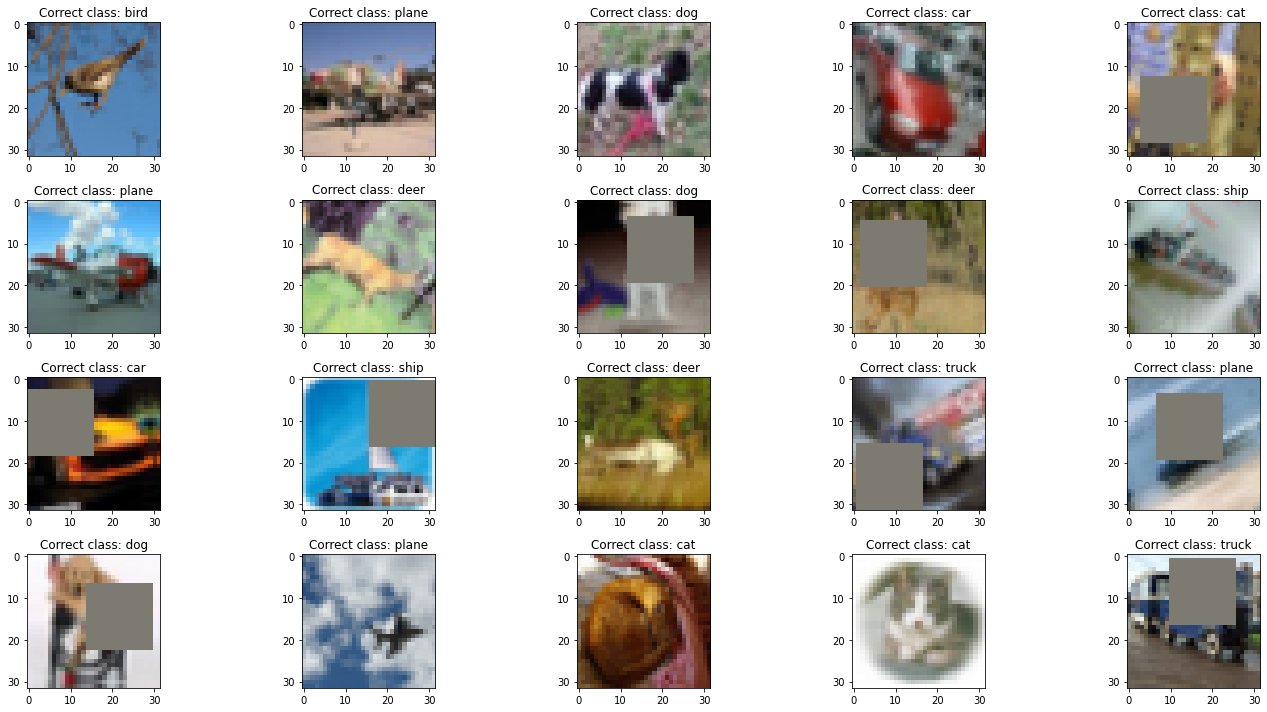

In [71]:
show_training_images(train_loader, 20)

# **Helper to show misclassified images**

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def show_misclassified_images(model, test_loader, device):
    model.eval()
    classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
    )
    misclassified_images = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append({'image': data[i], 'predicted_class': classes[pred[i]], 'correct_class': classes[target[i]]})

    # Plot the misclassified images
    fig = plt.figure(figsize=(20, 10))
    for i in range(20):
        sub = fig.add_subplot(4, 5, i+1)
        misclassified_image = misclassified_images[i]
        npimg = denormalize(misclassified_image['image'].cpu().numpy().squeeze())
        plt.imshow(npimg, cmap="gray")
        sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
    plt.tight_layout()
    plt.show()

# **Misclassified images**

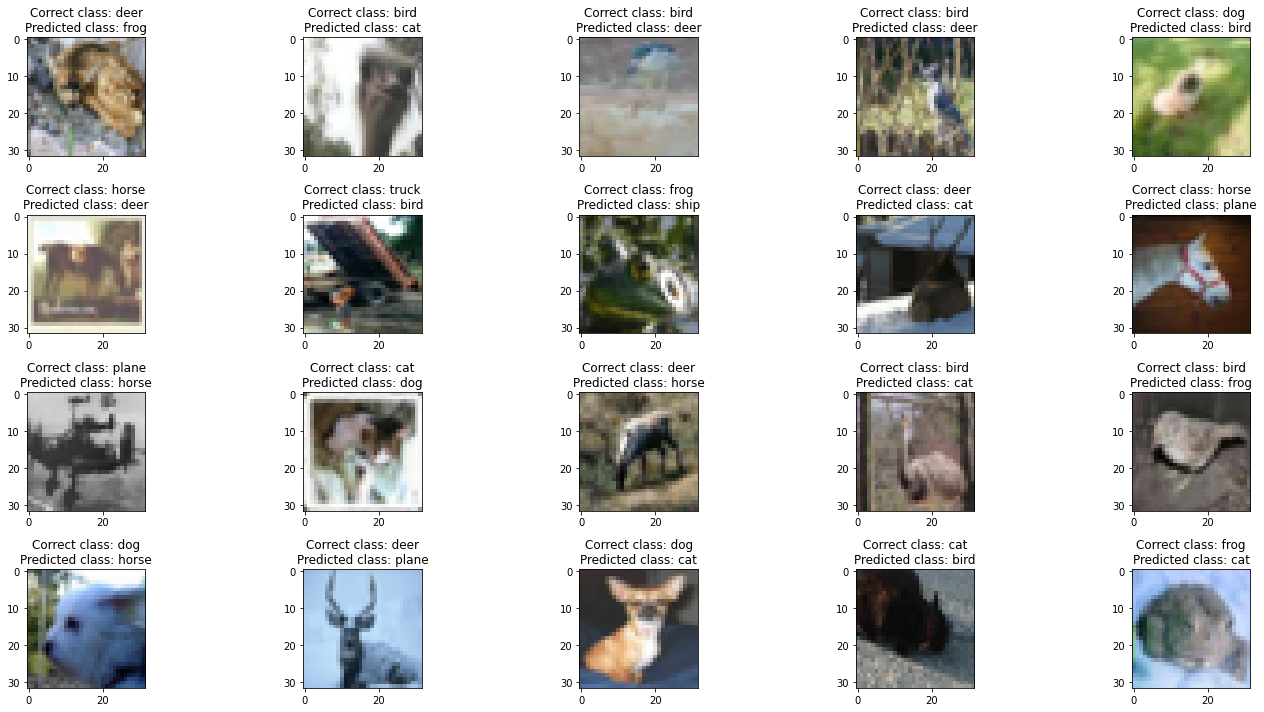

In [43]:
show_misclassified_images(model, test_loader, device)

# **Loss and Accuracy Graphs**

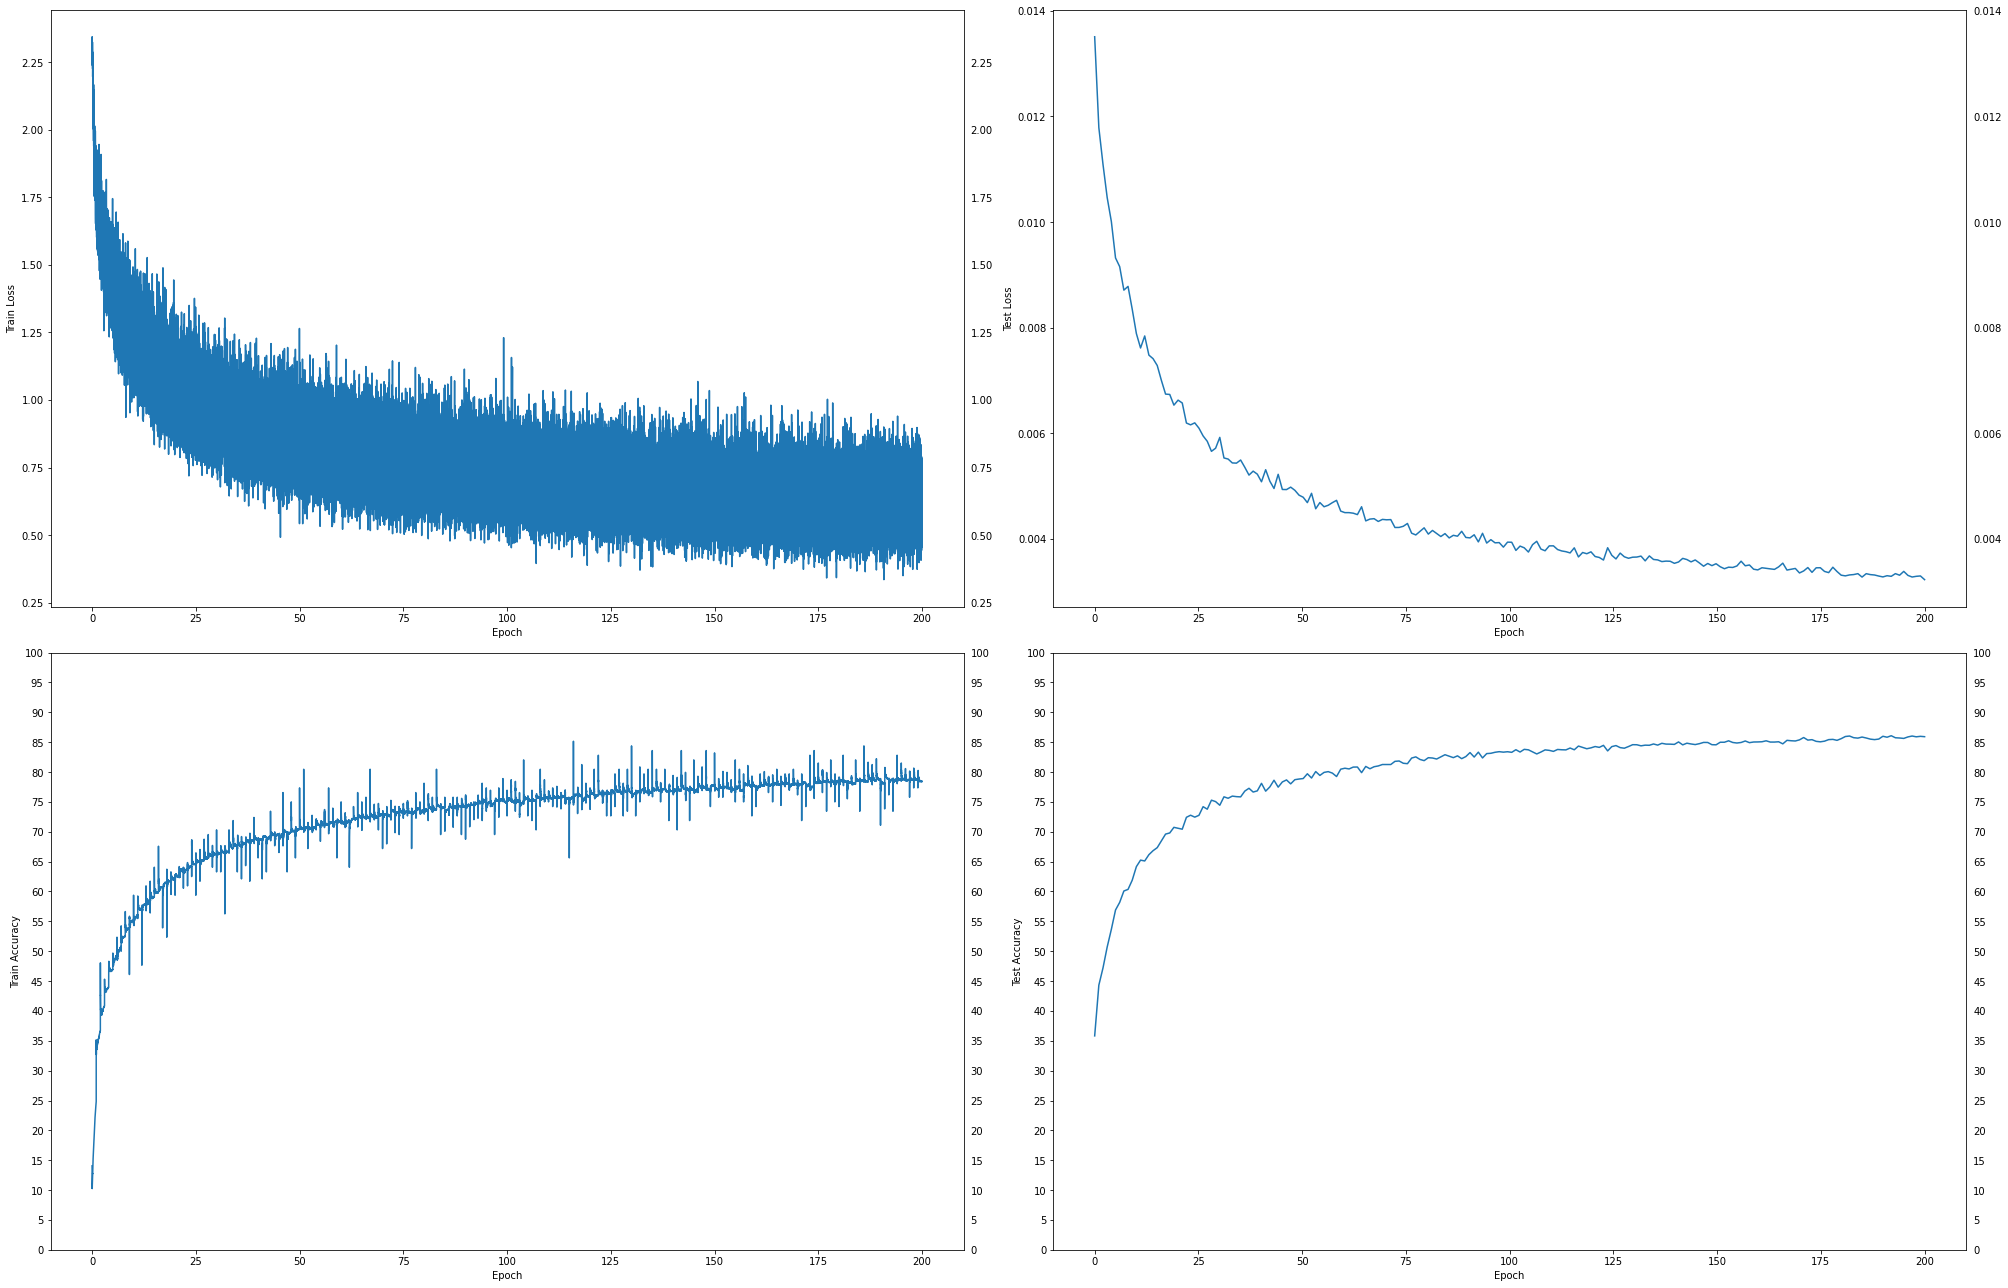

In [56]:
fig, ax = plt.subplots(2, 2)

train_epoch_loss_linspace = np.linspace(0, EPOCHS, len(trainer.train_losses))
test_epoch_loss_linspace = np.linspace(0, EPOCHS, len(tester.test_losses))
train_epoch_acc_linspace = np.linspace(0, EPOCHS, len(trainer.train_accuracies))
test_epoch_acc_linspace = np.linspace(0, EPOCHS, len(tester.test_accuracies))

ax[0][0].set_xlabel('Epoch')
ax[0][0].set_ylabel('Train Loss')
ax[0][0].plot(train_epoch_loss_linspace, trainer.train_losses)
ax[0][0].tick_params(axis='y', labelleft=True, labelright=True)

ax[0][1].set_xlabel('Epoch')
ax[0][1].set_ylabel('Test Loss')
ax[0][1].plot(test_epoch_loss_linspace, tester.test_losses)
ax[0][1].tick_params(axis='y', labelleft=True, labelright=True)

ax[1][0].set_xlabel('Epoch')
ax[1][0].set_ylabel('Train Accuracy')
ax[1][0].plot(train_epoch_acc_linspace, trainer.train_accuracies)
ax[1][0].tick_params(axis='y', labelleft=True, labelright=True)
ax[1][0].yaxis.set_ticks(np.arange(0, 101, 5))

ax[1][1].set_xlabel('Epoch')
ax[1][1].set_ylabel('Test Accuracy')
ax[1][1].plot(test_epoch_acc_linspace, tester.test_accuracies)
ax[1][1].tick_params(axis='y', labelleft=True, labelright=True)
ax[1][1].yaxis.set_ticks(np.arange(0, 101, 5))

fig.set_size_inches(28, 18)
plt.tight_layout()
plt.show()